In [ ]:
# pull data from polygon
import datetime
import numpy as np
from scipy.signal import detrend
import requests

def pull_data(ticker, api_key):
    # Define the date range
    end_datetime = datetime.datetime.now()
    start_datetime = end_datetime - datetime.timedelta(days = 365)


    # Polygon API endpoint for aggregate bars
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_datetime.date()}/{end_datetime.date()}?adjusted=true&apiKey={api_key}"
    
    # Fetch the data
    response = requests.get(url)
    data = response.json()

    if 'results' not in data:
        raise ValueError(f"Error fetching data: {data}")

    # Convert data to arrays
    times = np.array([entry['t'] for entry in data['results']])  # Timestamps
    close = np.array([entry['c'] for entry in data['results']])  # Closing prices

    # Detrend closing prices
    detrended_close = detrend(close)

    return times, close, detrended_close, data

# Example usage:
key = 'jjeryxeZXNkBhTEQF0SDj8uBBI_N1dBM'	
ticker = 'AAPL'
_,close,detrended,df= pull_data(ticker,key)
_,close2,detrended2,df2= pull_data('AMZN',key)


In [5]:
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
import fcwt
# Compute the wavelet coherence
def wavelet_coherence(signal1,signal2,highest,lowest,nfreqs,frame_rate):
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,)
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2], S12

lowest = 2 # days
highest = 100 # days

coherence, freqs, coeffs, S12 = wavelet_coherence(detrended, detrended2, 1/lowest, 1/highest, 100, 1)

NameError: name 'detrended' is not defined

In [174]:
def coherence_plot_with_arrows(coherence, freqs, S12,**kwargs):
    extent = [0, coherence.shape[1], len(freqs), 0]
    sampling_rate = kwargs.get('sampling_rate', 250)  # Default to 1 if not provided
    # Normalize coherence for color map
    #coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())
    m = .8
    #norm_coh = np.where(norm_coh < .8, -norm_coh**2 + 1,)

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > .7
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = extent[1] // 25  # Adjust this value to control the number of arrows
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coherence.shape[1], len(freqs),0]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap=parula_map)
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, width=0.003, headwidth=4, headlength=3.5, headaxislength=4)

    dt = 1 / sampling_rate


    # Axes labels and ticks
    ax.set_yticks(subsampled_indices)
    ax.set_yticklabels(subsampled_y_values.round(2))
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5),labels=np.linspace(0, coherence.shape[1] * dt, 5).round(2))
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    #ax.set_title('Wavelet Coherence', fontsize=16)
    fig.colorbar(im, ax=ax)
    #ax.legend()

    return fig



In [92]:
from multiprocessing import Process, Queue
import numpy as np
import tracemalloc
import pycwt

mother = pycwt.Morlet(6)

# Dummy test data
sampling_rate = 8000
nfreqs = 100
t = np.arange(0, 1, 1 / sampling_rate)
noise1 =np.random.randn(len(t))
noise2 =np.random.randn(len(t))
def compute_wavelet_params(f_min, f_max, nscales, dt, f_c=0.8125):
    a_min = f_c / f_max
    a_max = f_c / f_min
    dj = np.log2(a_max / a_min) / nscales
    s0 = a_min * dt
    J = nscales - 1
    return dj, s0, J

def run_coherence_a(q):
    tracemalloc.start()
    coh, _ = wavelet_coherence(noise1, noise2, 4000, 200, 100, sampling_rate)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    q.put(f"Coherence A: Peak RAM = {peak / 1024 / 1024:.2f} MB")

def run_coherence_b(q):

    dj, s0, J = compute_wavelet_params(200, 4000, nfreqs, 1 / sampling_rate)

    tracemalloc.start()
    coh2, *_ = pycwt.wct(noise1, noise2, 1 / sampling_rate, dj=dj, s0=s0, J=J, wavelet=mother, sig=False)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    q.put(f"Coherence B: Peak RAM = {peak / 1024 / 1024:.2f} MB")




In [93]:


# --- WAVELET COHERENCE FUNCTION ---
def wavelet_coherence(signal1, signal2, highest_freq, lowest_freq, nfreqs, sampling_rate):
    freqs, coeffs1 = fcwt.cwt(signal1, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    _, coeffs2 = fcwt.cwt(signal2, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coherence = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coherence, freqs

def coherence(coeffs1, coeffs2, freqs):
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coh = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coh, freqs, S12


In [182]:
def transform(signal1,frame_rate,highest,lowest,**kwargs):
    #sampling_rate = kwargs.get('sampling_rate', 250)
    nfreqs = 100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')

    return coeffs1,freqs

def transform_plot(signal,frame_rate,highest,lowest):


    coeffs1,freqs = transform(signal,frame_rate,highest,lowest)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Magnitude')
    cbar.set_ticks([])  
    plt.xlabel('Time (Years)')
    plt.ylabel('Frequency (per year)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()
    return coeffs1,freqs

#transform_plot(detrended2,250,125,3)

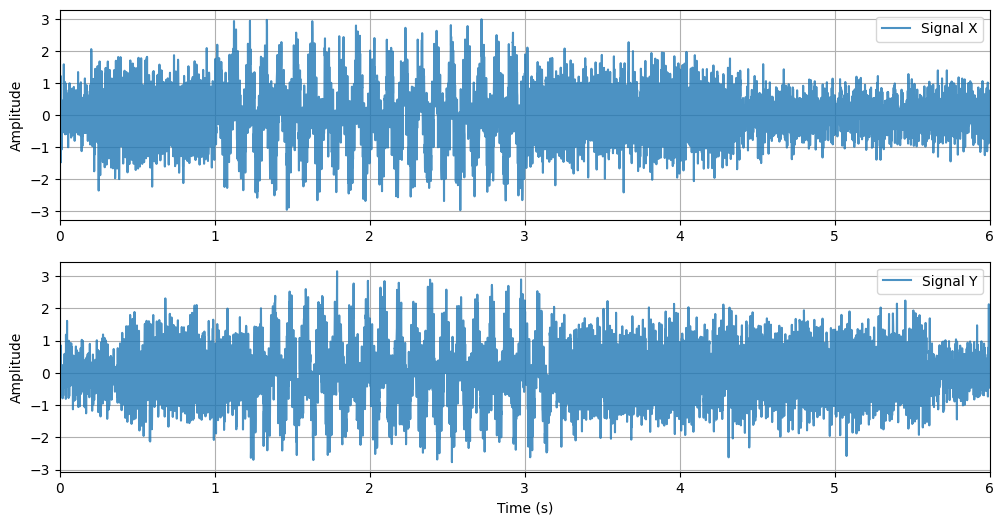

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling rate
duration = 6  # seconds
t = np.arange(0, duration, 1/fs)

# Frequencies
f1 = 10    # Hz
f2 = 75    # Hz

# Phase lag: 1/4 cycle = π/2 radians
phase_shift10 = 3* np.pi / 4
phase_shift75 = np.pi / 4

# Time-localized windows
mask_10hzx = (t >= 1) & (t <= 3.0)
mask_75hzx = (t >= 0.2) & (t <= 4.4)

mask_10hzy = (t >= 1.2) & (t <= 3.2)
mask_75hzy = (t >= 0.4) & (t <= 5.6)

# Signal X (no phase shift)
x = np.zeros_like(t)
x[mask_10hzx] += np.sin(2 * np.pi * f1 * t[mask_10hzx])
x[mask_75hzx] += np.sin(2 * np.pi * f2 * t[mask_75hzx])

# Signal Y (π/2 phase shift)
y = np.zeros_like(t)
y[mask_10hzy] += np.sin(2 * np.pi * f1 * t[mask_10hzy] + phase_shift10)
y[mask_75hzy] += np.sin(2 * np.pi * f2 * t[mask_75hzy] + phase_shift75)

# Add white Gaussian noise
noise_level = 0.5
x += np.random.normal(0, noise_level, size=t.shape)
y += np.random.normal(0, noise_level, size=t.shape)
fig,ax = plt.subplots(2,1,figsize=(12,6))
# Plot
ax[0].plot(t, x, label='Signal X', alpha=0.8)
ax[0].set_xlim(0, 6)
#ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
#ax[0].set_title("Signal X")
ax[0].legend()
ax[0].grid(True)
ax[1].plot(t, y, label='Signal Y', alpha=0.8)
ax[1].set_xlim(0, 6)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
#ax[1].set_title("Signal Y")
ax[1].legend()
ax[1].grid(True)



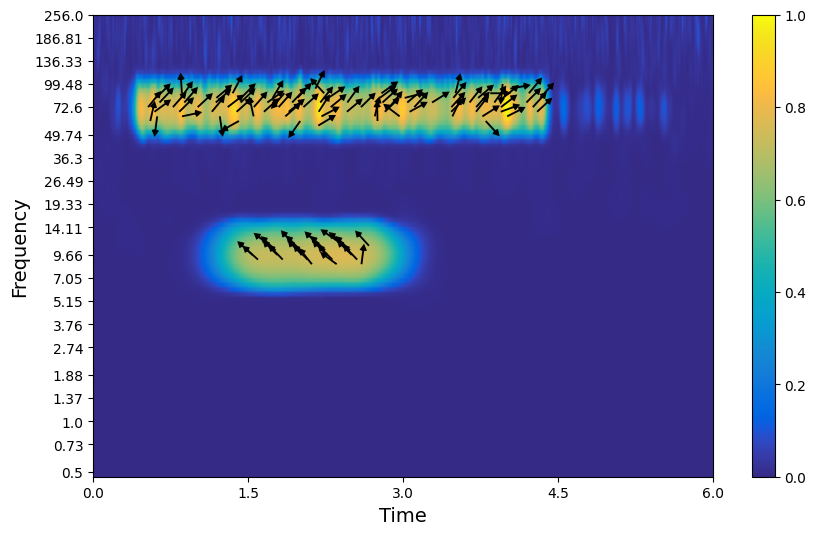

In [186]:
def coherence_plot(coh,freqs,sampling_rate):
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coh.shape[1]/sampling_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(coh, aspect='auto', extent=extent, cmap='Blues')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    plt.colorbar(label='Coherence')
    plt.xlabel('Time (years)')
    plt.ylabel('Frequency (per year)')
    plt.title('Wavelet Coherence')
    plt.tight_layout()
    plt.show()

def workflow(sig1,sig2,bounds,phase = True):
    sampling_rate = 1000 # Assuming days per year
    highest = bounds[0]
    lowest = bounds[1]
    t1,_ = transform(sig1, sampling_rate, highest, lowest)
    t2,freqs = transform(sig2, sampling_rate, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12,sampling_rate = sampling_rate) 
    else:
        coherence_plot(coh, freqs, 250)
    return freqs,S12,coh


freqs,_,_ = workflow(y,x,[256,0.5]);

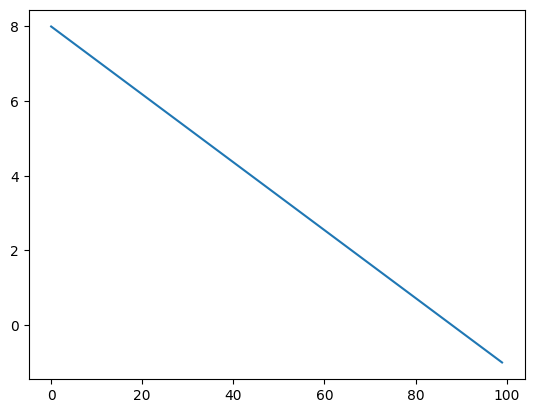

In [195]:
plt.plot(np.log2(freqs), label='Frequency')

viscm not found, falling back on simple display


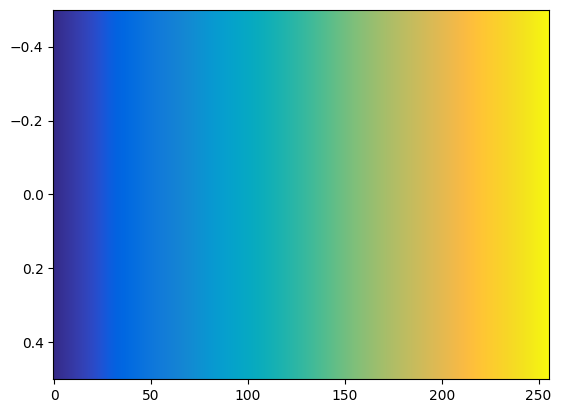

In [156]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
# For use of "viscm view"
test_cm = parula_map

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np

    try:
        from viscm import viscm
        viscm(parula_map)
    except ImportError:
        print("viscm not found, falling back on simple display")
        plt.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto',
                   cmap=parula_map)
    plt.show()

In [20]:
import numpy as np

def generate_nonstationary_signal(duration, sampling_rate, freq_range):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.zeros_like(t)

    # Embed frequencies within the specified range
    for freq in np.linspace(freq_range[0], freq_range[1], num=5):  # 5 frequencies
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2 * np.pi)  # Random phase
        modulation = np.exp(-0.5 * ((t - duration / 2) / (duration / 4))**2)  # Gaussian envelope
        signal += amplitude * modulation * np.sin(2 * np.pi * freq * t + phase)

    # Add random noise
    signal += 0.2 * np.random.randn(len(t))
    return t, signal

# Parameters
duration = 10  # seconds
sampling_rate = 250  # Hz
freq_range = (10, 100)  # Hz

In [ ]:
# filename: wavelet_dashboard.ipynb

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Your functions: transform, coherence, coherence_plot, coherence_plot_with_arrows, pull_data

def workflow(sig1, sig2, bounds, phase=True):
    sampling_rate = 250  # days/year
    highest, lowest = bounds
    t1, _ = transform(sig1, sampling_rate, highest, lowest)
    t2, freqs = transform(sig2, sampling_rate, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    
    #fig = plt.figure(figsize=(10, 6));
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12)
    else:
        coherence_plot(coh, freqs, sampling_rate)
    plt.show()

    return freqs, S12, coh

# --- Widgets ---
ticker1 = widgets.Text( description='Stock 1:')
ticker2 = widgets.Text( description='Stock 2:')
upper_bound = widgets.IntSlider(value=125, min=20, max=250, step=5, description='Max Period:')
lower_bound = widgets.IntSlider(value=8, min=2, max=50, step=1, description='Min Period:')
phase_toggle = widgets.Checkbox(value=True, description='Show Phase Arrows')
run_button = widgets.Button(description='Run Analysis')

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

output = widgets.Output()

def on_run_clicked(b):
    with output:
        clear_output(wait=True)
        sig1 = pull_data(ticker1.value, key)[2]
        sig2 = pull_data(ticker2.value, key)[2]
        bounds = (upper_bound.value, lower_bound.value)
        workflow(sig1, sig2, bounds, phase=phase_toggle.value)

run_button.on_click(on_run_clicked)

# Layout
ui = widgets.VBox([
    widgets.HBox([ticker1, ticker2]),
    upper_bound,
    lower_bound,
    phase_toggle,
    run_button,
    output
])

display(ui)


In [3]:
import pywavelets as pywt
import numpy as np

# Example signal (length 8)
x = np.array([3, 7, 1, 1, -2, 5, 4, 6])

# Perform single-level DWT using Haar wavelet
cA, cD = pywt.dwt(x, 'haar')

# Print approximation and detail coefficients
print("Approximation coefficients (cA):", np.round(cA, 2))
print("Detail coefficients (cD):", np.round(cD, 2))


ModuleNotFoundError: No module named 'pywavelets'